In [1]:
import spinmob as s
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
import mcphysics as m
import seaborn as sns

# make plt plot inline
%matplotlib inline


  To disable warnings, set spinmob.settings['ignore_warnings']=True


1. conda install pip spyder pyqtgraph
2. pip install spinmob mcphysics imageio sounddevice

## Loading in the data

Calibration & Lead runs

In [2]:
user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'
folder_path = user_path + '/PHYS469/alpha_decay/raw_data/'  # path to data folder

am_data = m.data.load_chn(folder_path + 'am_source.chn')
pb_data = m.data.load_chn(folder_path + 'lead2_extended.chn')
calibration_data = m.data.load_chn(folder_path + 'calibration_new/channel_counts.chn')

channels = calibration_data.columns['Channel']
am_counts = am_data.columns['Counts']
pb_counts = pb_data.columns['Counts']  
pulser_counts = calibration_data.columns['Counts'] 

Pressure runs

In [3]:
pressure_data_dict = {}
for p in [0, 100, 225]:
    pressure_data_dict[p] = m.data.load_chn(folder_path + f'{p}mbar.Chn')

In [4]:
pressure_data_dict[0].columns['Channel'], pressure_data_dict[0].columns['Counts']

(array([   0,    1,    2, ..., 2045, 2046, 2047]),
 array([0, 0, 0, ..., 0, 0, 0]))

## Adding in new calibration runs

In [5]:
folder_path = user_path + '/PHYS469/alpha_decay/raw_data/calibration_new'

# making an array of channel-voltage pais, where the channel is the file name and the voltage is the peak y value in each file 
# txt files, headers are on row 29

# get all the files in the folder
files = os.listdir(folder_path)

# sort the files by channel number
files.sort()
files.remove('channel_counts.Chn')

# initialize the array
pulser_voltages = []
pulser_channels = []

# loop through the files
for file in files:
    # read the file
    data = np.genfromtxt(folder_path + '/' + file, skip_header=29)
    # get the peak y value
    peak = max(data[:,1])
    # # get the channel number
    channel = int(file.split('.')[0])
    # # add the pair to the array
    pulser_voltages.append(peak)
    pulser_channels.append(channel)

voltage_err = 0.0001

## Creating the energy scale

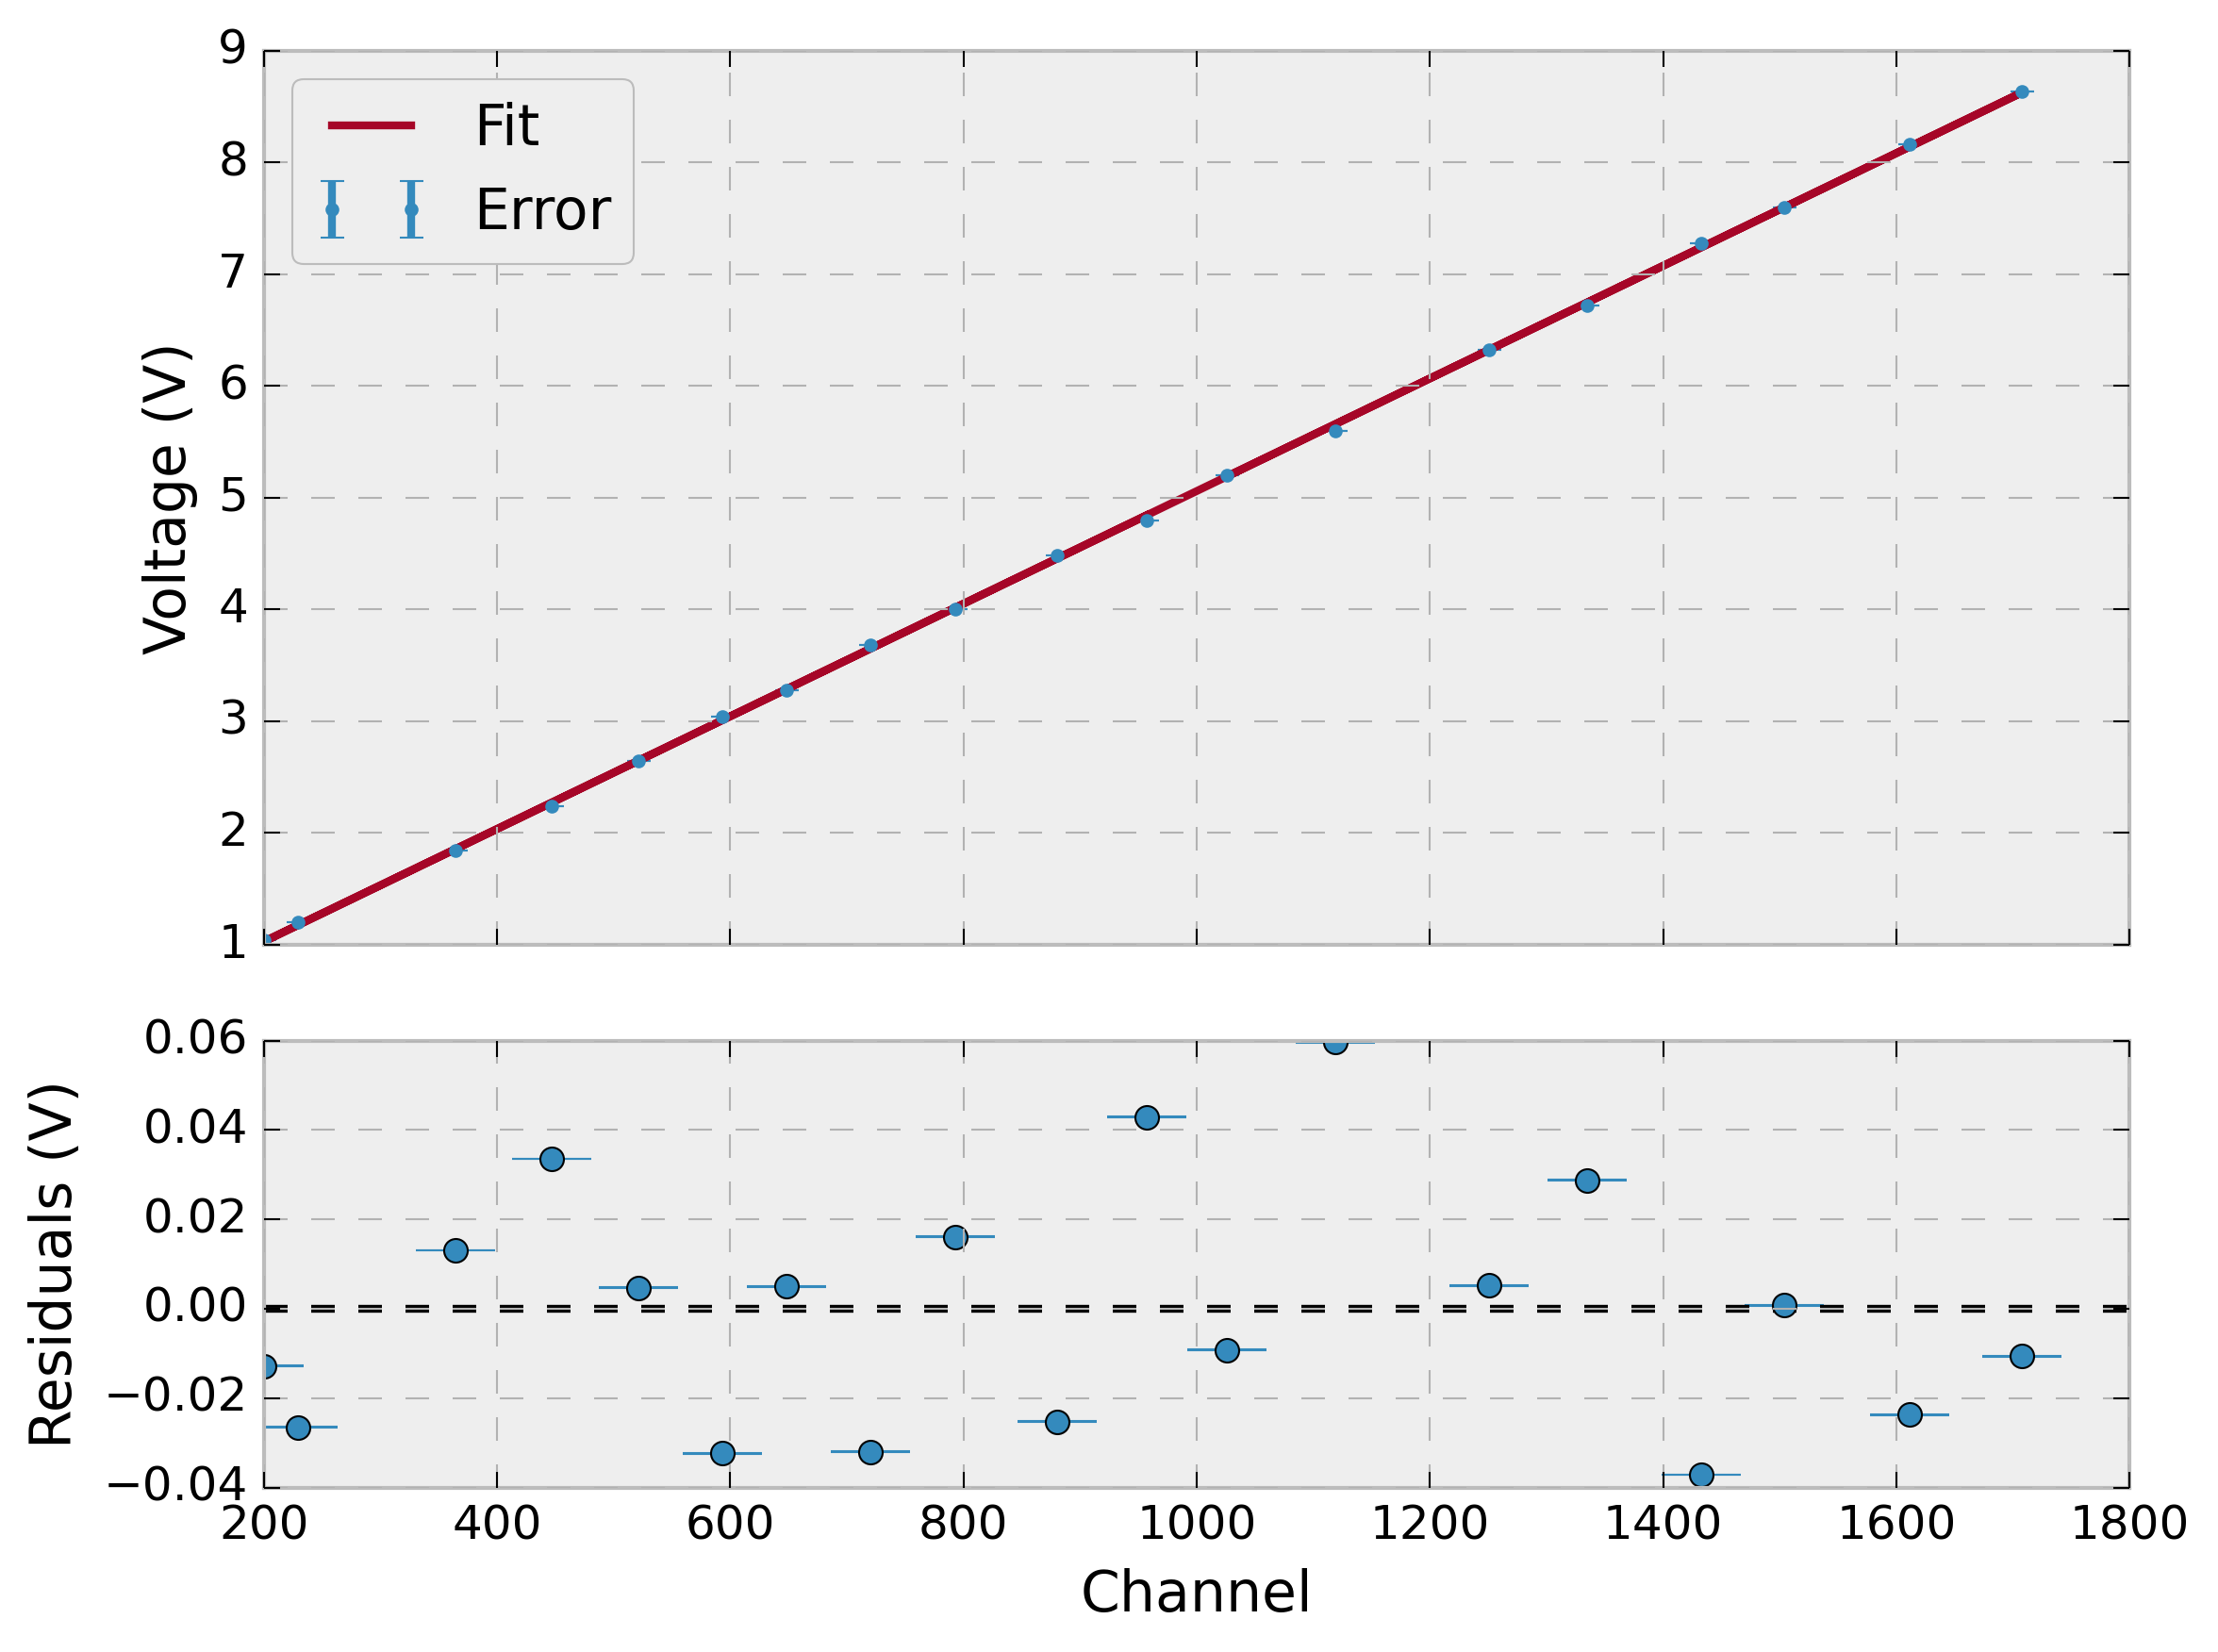

In [45]:
def line(channels, m, b):
    channels = np.array(channels)
    return m * channels + b

# using the Americium to get a known point: 
am_peak = np.where(am_counts == np.max(am_counts))[0][0]

# fit the calibration data
popt, pcov = opt.curve_fit(line, pulser_channels, pulser_voltages, p0=[1, 0])
m, b = popt
m_err = np.sqrt(pcov[0,0])
b_err = np.sqrt(pcov[1,1])

# plot the fit and residuals
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), dpi = 300, gridspec_kw={'height_ratios': [2, 1]})

# Main plot
ax1.errorbar(pulser_channels, pulser_voltages, yerr=voltage_err, fmt='.', label='Error')
ax1.plot(pulser_channels, line(pulser_channels, m, b), label='Fit')
ax1.set_ylabel('Voltage (V)')
ax1.legend(loc = 'upper left')

# Residuals plot
ax2.errorbar(pulser_channels, line(pulser_channels, m, b) - pulser_voltages, yerr=voltage_err, fmt='o', capsize = 10)
ax2.axhline(0, color='black', linestyle='--')
ax2.set_xlabel('Channel')
ax2.set_ylabel('Residuals (V)')

plt.tight_layout()
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/calibration.pdf', bbox_inches='tight')
plt.show()

### Fitting the americium energy

In [53]:
# Converting to energy scale
voltages = m * channels + b

# error propagation from fit onto voltages
voltage_err = np.sqrt(channel**2 * m_err**2 + b_err**2)

am_peak_energy = 5.486 # MeV
am_peak_channel = channels[am_peak]

am_peak_voltage = m * am_peak_channel + b
am_peak_voltage_err = 0.0001 # from measurements

energy = am_peak_energy * voltages / am_peak_voltage
energy_err = energy * np.sqrt((am_peak_voltage_err/am_peak_voltage)**2 + (voltage_err/voltages)**2)

# error on counts = sqrt(counts) for any counts (poisson statistics)

## Identifying lead peaks

In [54]:
# finding the peaks in the lead spectrum. note: highest peak is from us leaving the pulser on

# getting local maxima in spectra
peaks = []
for i in range(1, len(pb_counts) - 1000):
    if pb_counts[i] > 500:
        if pb_counts[i] > pb_counts[i - 1] and pb_counts[i] > pb_counts[i + 1]:
            peaks.append(i)

print(f'The peaks are at channels: {peaks}, corresponding to energies: {energy[peaks]} +- {energy_err[peaks]} MeV.')

# uncertainties?

The peaks are at channels: [521, 751], corresponding to energies: [6.07684353 8.74143202] +- [0.04564538 0.04564614] MeV.


## Making the multipanel

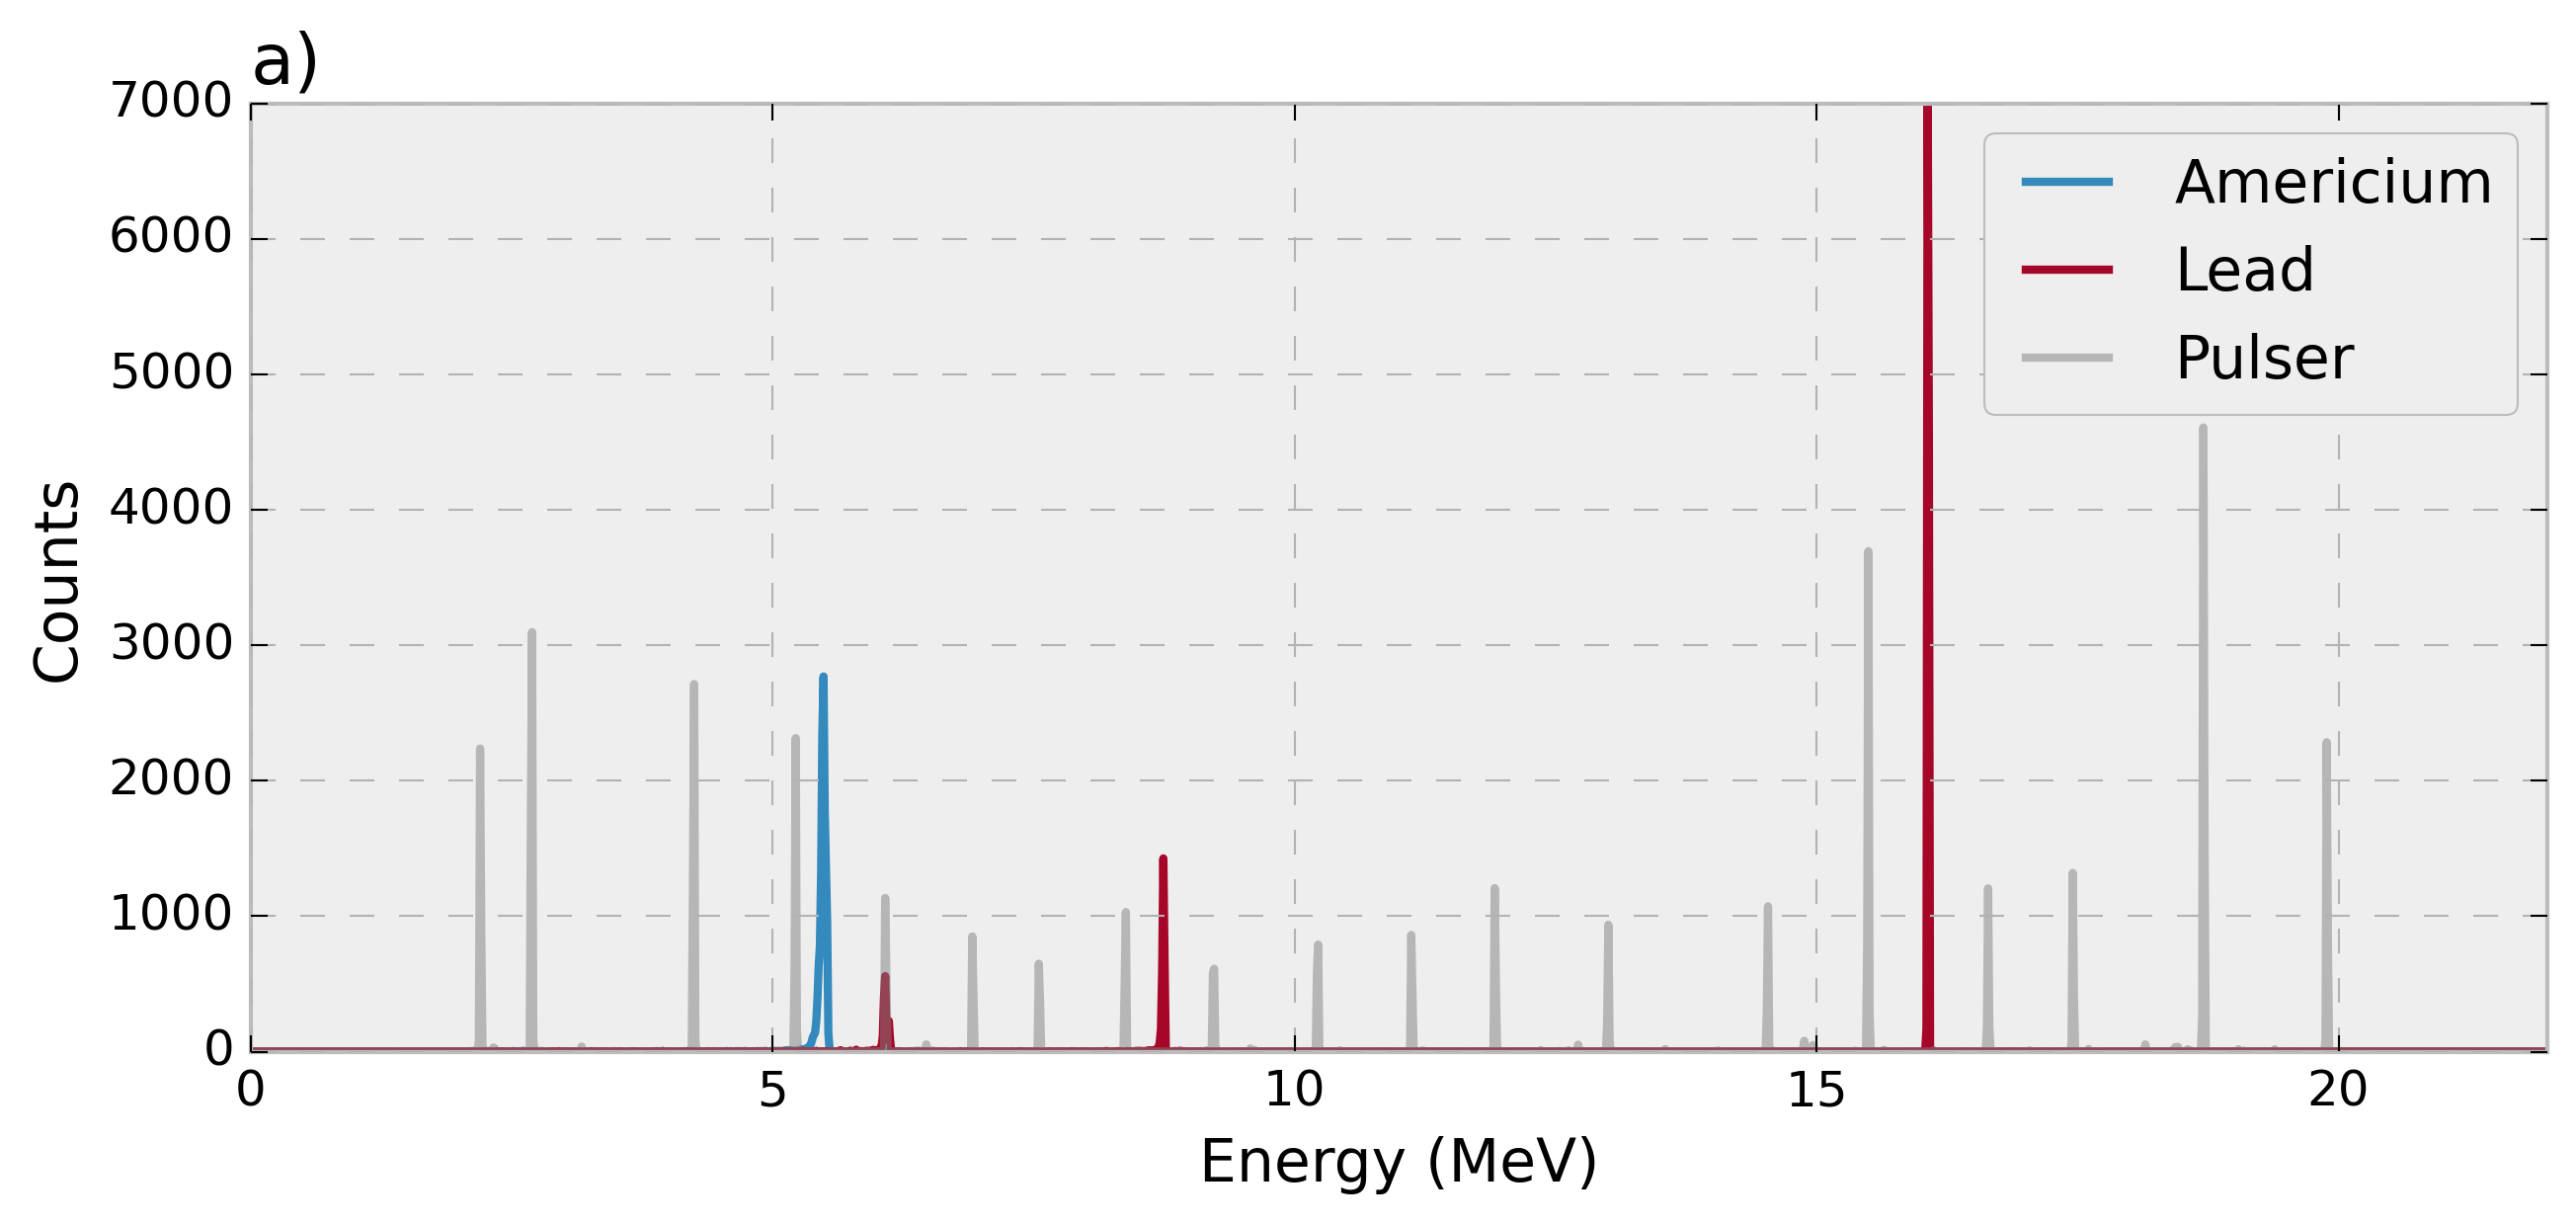

In [55]:
# plotting the spectra with our americium calibration data and the lead data 
plt.style.use('bmh')

plt.figure(figsize = (10, 4), dpi = 300)
plt.plot(energy, am_counts, label='Americium')
plt.plot(energy, pb_counts, label='Lead')
plt.plot(energy, pulser_counts, label='Pulser', color = 'grey', alpha = 0.5)
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.legend( loc = 'upper right', frameon = True)
plt.xlim(0, 22)
plt.ylim(0, 7000)
plt.title('a)', loc = 'left')
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/spectra.pdf', bbox_inches='tight')
plt.show()

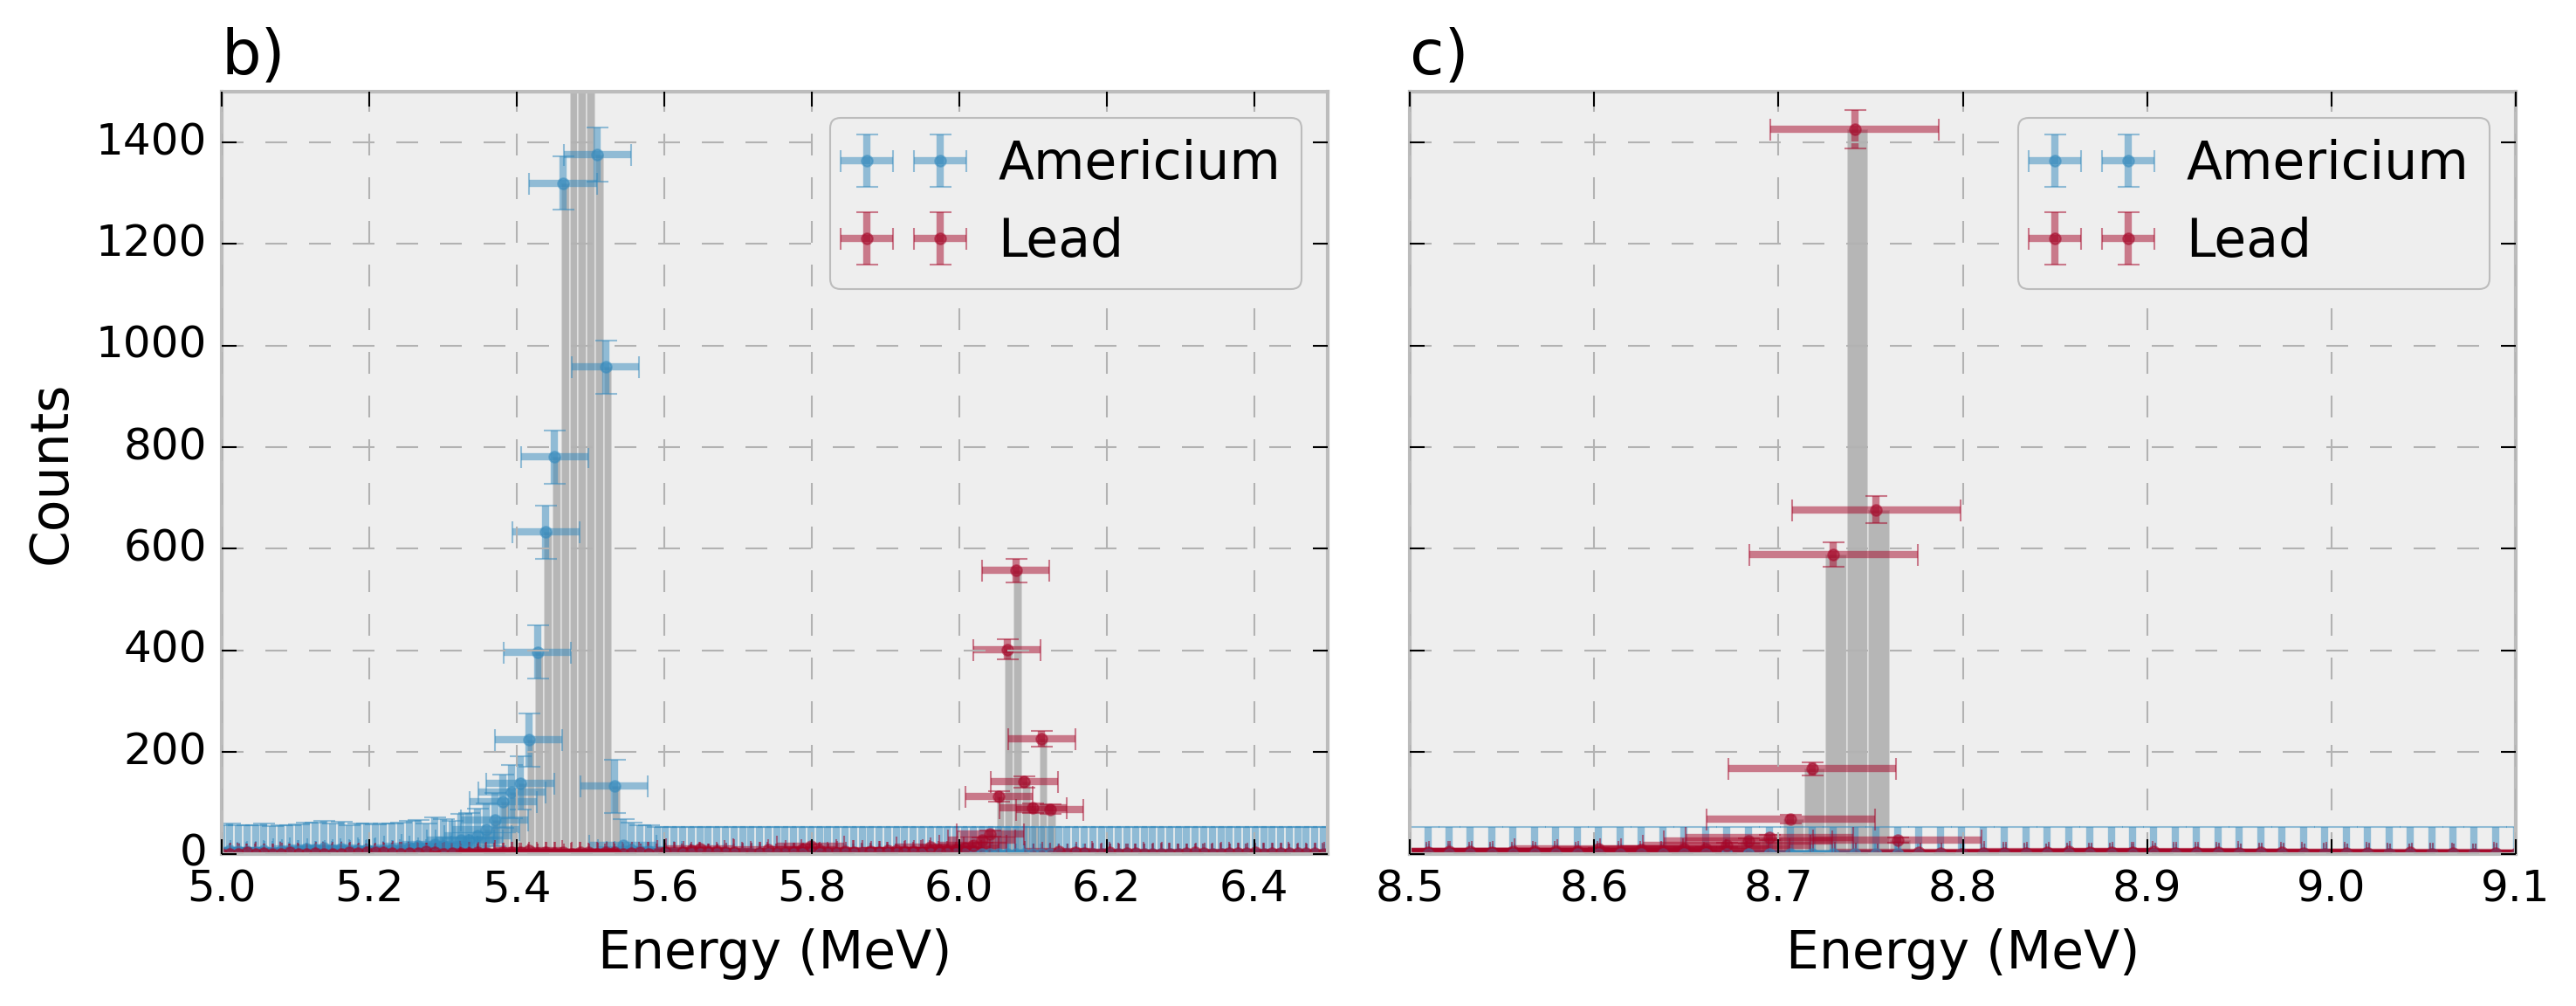

In [56]:
# zooming in on the lead spectrum and plotting  with errors
from importlib import reload
reload(plt)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300, sharey=True)

# Left subplot
ax[0].hist(energy, bins=len(channels), weights=pb_counts, color='gray', alpha=0.5)
ax[0].hist(energy, bins=len(channels), weights=am_counts, color='gray', alpha=0.5)
ax[0].errorbar(energy, am_counts, xerr=energy_err, yerr=am_counts_err, fmt='.', label='Americium', alpha=0.5)
ax[0].errorbar(energy, pb_counts, xerr=energy_err, yerr=pb_counts_err, fmt='.', label='Lead', alpha=0.5)
ax[0].set_xlabel('Energy (MeV)')
ax[0].set_ylabel('Counts')
ax[0].legend(loc='upper right', frameon=True)
ax[0].set_title('b)', loc = 'left')
ax[0].set_xlim(5, 6.5)
ax[0].set_ylim(0, 1500)

# Right subplot
ax[1].hist(energy, bins=len(channels), weights=pb_counts, color='gray', alpha=0.5)
ax[1].hist(energy, bins=len(channels), weights=am_counts, color='gray', alpha=0.5)
ax[1].errorbar(energy, am_counts, xerr=energy_err, yerr=am_counts_err, fmt='.', label='Americium', alpha=0.5)
ax[1].errorbar(energy, pb_counts, xerr=energy_err, yerr=pb_counts_err, fmt='.', label='Lead', alpha=0.5)
ax[1].set_xlabel('Energy (MeV)')
ax[1].set_title('c)', loc = 'left')
ax[1].legend(loc='upper right', frameon=True)
ax[1].set_xlim(8.5, 9.1)

plt.tight_layout()
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/zoom.pdf', bbox_inches='tight')
plt.show()

## Pressure Analysis